# Сервис по продаже автомобилей с пробегом «Не бит, не крашен» 

## Задание

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных 

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя


Целевой признак


- **Price** — цена (евро)

## Подключение библиотек 

In [13]:
import pandas as pd

!pip install seaborn -U
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

/bin/bash: pip: команда не найдена


## Подготовка данных

### Загрузка данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Вывод

Пропуски содержаться в следующих полях:

- VehicleType
- Gearbox
- Model
- FuelType
- NotRepaired

Неправильный тип данных у следующих полей:

- DateCrawled - **date**
- NotRepaired - **bool**
- DateCreated - **date**
- LastSeen    - **date**

### Обработка пропусков 

#### Поля Gearbox, Model, FuelType, Brand 

Ясно, что эти поля влияют друг на друга, заполним их методом К ближайших соседний.

##### Подготовка данных 

In [17]:
data_tmp = data.dropna()[['VehicleType','Gearbox','Model','FuelType','Brand']]

In [18]:
data_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 5 columns):
VehicleType    245814 non-null object
Gearbox        245814 non-null object
Model          245814 non-null object
FuelType       245814 non-null object
Brand          245814 non-null object
dtypes: object(5)
memory usage: 11.3+ MB


In [19]:
data_tmp.head()

,VehicleType,Gearbox,Model,FuelType,Brand
3,small,manual,golf,petrol,volkswagen
4,small,manual,fabia,gasoline,skoda
5,sedan,manual,3er,petrol,bmw
6,convertible,manual,2_reihe,petrol,peugeot
7,sedan,manual,other,petrol,volkswagen


### Кодирование признаков 

### Поле Price

In [8]:
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [9]:
def visualize():
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(16, 10))    
    fig.suptitle('Распределения поля Price')
    
    ax = axes.flat
    
    axes[0].set_xlabel('Цена в евро')
    data.boxplot('Price',vert=False,  ax=ax[0])
    
    axes[1].set_ylabel('Относительная частота')
    axes[1].set_xlabel('Цена в евро')
    sns.histplot(data['Price'], kde=True, stat="probability", ax=ax[1])
    plt.show()

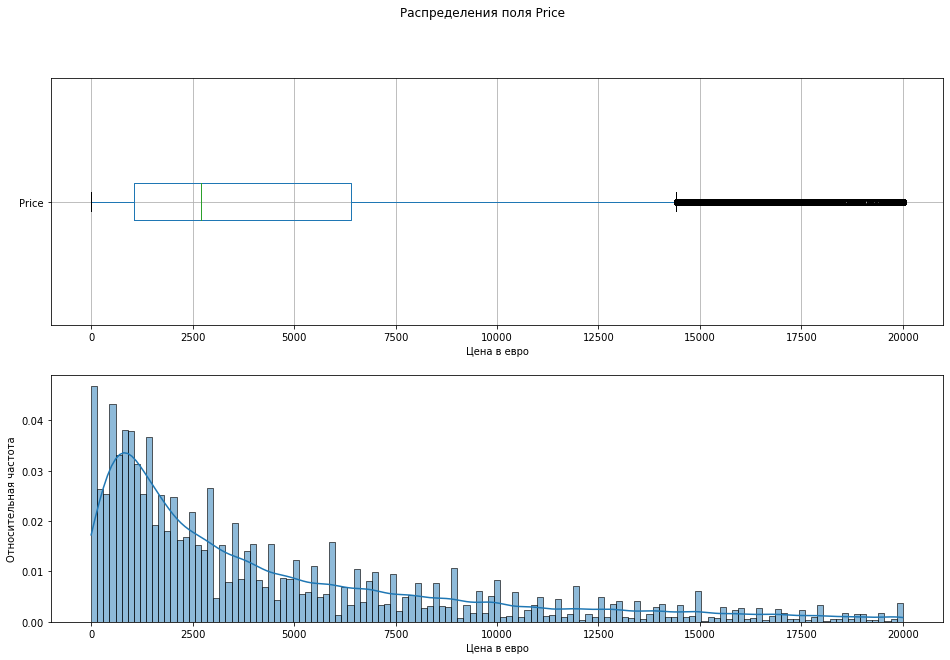

In [10]:
visualize()

#### Вывод

Поле имеет логнормальное распределение и не содержит выбросов. Однако машины с нулевой ценой вызывают подозрение, рассмотрим их отдельно.

### Деление выборки на features и target 

In [11]:
def split_x_y(data, column):
    x = data.drop(column, axis=1)
    y = data[column]
    return x, y

In [12]:
features, target  = split_x_y(data,'Price')

### Обработка полей не влияющих на цену 

Предположим, что на цену не влияют следующие поля:
    
- DateCrawled
- RegistrationMonth
- DateCreated
- NumberOfPictures
- PostalCode
- LastSeen

Проверим наши предположения 

# 2. Обучение моделей

# 3. Анализ моделей

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей